# Infer MLE Params
Miguel Fuentes  
Created: 5/3/2020  
Last Updated: 5/4/2020

In [1]:
%matplotlib inline
from infection_models import sample_transmission

from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt

import torch
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import plate

pyro.set_rng_seed(101)

## Generate Data
First, I'll sample from "sample_transmission". This model is fully defined so I know what distributions all the paramaters are set to and what all the latent variables are coming from. I will only record the protocol which was used and how many people the individual infected, not the two latent variables.

In [2]:
n = 1000
data = []

for _ in range(n):
    protocol, contacted_people, infection_rate, num_infected = sample_transmission()
    data.append((protocol, num_infected))

## VI with Matching Guide
First, I will run inference using a guide which has the same form as the actual model, I expect that this should work pretty well and converge to parameters which are equivalent to those for the data generating process

In [8]:
M = 10

def observe_transmission(data):
    normal_contact_loc = torch.tensor(50.0)
    normal_contact_scale = torch.tensor(10.0)
    normal_conc0 = torch.tensor(10.0)
    normal_conc1 = torch.tensor(10.0)

    distance_contact_loc = torch.tensor(25.0)
    distance_contact_scale = torch.tensor(5.0)
    distance_conc0 = torch.tensor(10.0)
    distance_conc1 = torch.tensor(10.0)

    num_infected_scale = pyro.param('num_infected_scale', torch.tensor(5.0), constraint=constraints.positive)
    
    for i in pyro.plate("data_loop", len(data), subsample_size=M):
        protocol, num_infected = data[i]
        if protocol == 'normal_behavior':
            contacted_people = pyro.sample(f'contacted_people_{i}', pyro.distributions.Normal(normal_contact_loc, normal_contact_scale))
            infection_rate = pyro.sample(f'infection_rate_{i}', pyro.distributions.Beta(normal_conc1, normal_conc0))
        elif protocol == 'social_distancing':
            contacted_people = pyro.sample(f'contacted_people_{i}', pyro.distributions.Normal(distance_contact_loc, distance_contact_scale))
            infection_rate = pyro.sample(f'infection_rate_{i}', pyro.distributions.Beta(distance_conc1, distance_conc0))
        else:
            raise ValueError(f'Data point {i} has protocol value {protocol}, expects values \'social_distancing\' or \'normal_behavior\'')
        num_infected_loc = contacted_people * infection_rate
        num_infected = pyro.sample(f'num_infected_{i}', pyro.distributions.Normal(num_infected_loc, num_infected_scale), obs=num_infected)
        
def matching_guide(data):
    q_normal_contact_loc = pyro.param('q_normal_contact_loc', torch.tensor(50.0), constraint=constraints.positive)
    q_normal_contact_scale = pyro.param('q_normal_contact_scale', torch.tensor(10.0), constraint=constraints.positive)
    q_normal_conc0 = pyro.param('q_normal_conc0', torch.tensor(10.0), constraint=constraints.positive)
    q_normal_conc1 = pyro.param('q_normal_conc1', torch.tensor(10.0), constraint=constraints.positive)

    q_distance_contact_loc = pyro.param('q_distance_contact_loc', torch.tensor(25.0), constraint=constraints.positive)
    q_distance_contact_scale = pyro.param('q_distance_contact_scale', torch.tensor(5.0), constraint=constraints.positive)
    q_distance_conc0 = pyro.param('q_distance_conc0', torch.tensor(10.0), constraint=constraints.positive)
    q_distance_conc1 = pyro.param('q_distance_conc1', torch.tensor(10.0), constraint=constraints.positive)
    
    for i in pyro.plate("data_loop", len(data), subsample_size=M):
        protocol, num_infected = data[i]
        if protocol == 'normal_behavior':
            contacted_people = pyro.sample(f'contacted_people_{i}', pyro.distributions.Normal(q_normal_contact_loc, q_normal_contact_scale))
            infection_rate = pyro.sample(f'infection_rate_{i}', pyro.distributions.Beta(q_normal_conc1, q_normal_conc0))
        elif protocol == 'social_distancing':
            contacted_people = pyro.sample(f'contacted_people_{i}', pyro.distributions.Normal(q_distance_contact_loc, q_distance_contact_scale))
            infection_rate = pyro.sample(f'infection_rate_{i}', pyro.distributions.Beta(q_distance_conc1, q_distance_conc0))
        else:
            raise ValueError(f'Data point {i} has protocol value {protocol}, expects values \'social_distancing\' or \'normal_behavior\'')


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 66.28it/s]


Text(0, 0.5, 'loss')

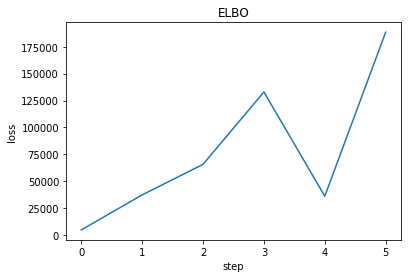

In [9]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=observe_transmission,
                     guide=matching_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses = []
num_steps =500
for _ in tqdm(range(num_steps)):
    losses.append(svi.step(data))
    

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [6]:
print_params = [
    'q_normal_contact_loc',
    'q_normal_contact_scale',
    'q_normal_conc0',
    'q_normal_conc1',
    'q_distance_contact_loc',
    'q_distance_contact_scale',
    'q_distance_conc0',
    'q_distance_conc1',
    'num_infected_scale',
]
for p in print_params:
    print(f'{p}: ', pyro.param(p).item())

q_normal_contact_loc:  nan
q_normal_contact_scale:  nan
q_normal_conc0:  nan
q_normal_conc1:  nan
q_distance_contact_loc:  nan
q_distance_contact_scale:  nan
q_distance_conc0:  nan
q_distance_conc1:  nan
num_infected_scale:  nan


In [10]:
losses[:10]

[4759.199417114258,
 37309.2700881958,
 65667.04272460938,
 132938.2597808838,
 36056.52862548828,
 188423.11514282227,
 nan,
 nan,
 nan,
 nan]